In [2]:
import pandas as pd
import numpy as np
import regex
import re
import string
from collections import Counter
from string import punctuation
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('classic')
import seaborn as sns
sns.set()
import plotly.graph_objects as go
import plotly.express as px
import pandas_profiling as pp

## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)



from wordcloud import WordCloud,STOPWORDS

#Natural Language Processing (NLP)
import spacy
import gensim
from gensim import corpora, models, similarities
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from spacy.tokenizer import Tokenizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
file_path = '/content/drive/MyDrive/MovieReviews/IMDB_Dataset.csv'

In [5]:
Movies_df = pd.read_csv(file_path)
print("Shape:",Movies_df.shape)

#Viewing the top 5 records
Movies_df.head(5)

Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
Movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
Movies_df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
sns.countplot(x=Movies_df['sentiment'])
plt.grid()

**Data Cleaning**

We have to clean the data: 1)Remove emojis and urls so we can tokenize it for the next steps. 2)Tokenize each tweet 3)Remove stop words, punctuation, and lowercase all words 4)Remove any remaining special characters and lemmatize text

In [9]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
def clean_data1(reviews):
    #removing URl links
    reviews = re.sub(r'http\S+', '', str(reviews))
    #lowercasing
    reviews=reviews.lower()
    #remove double spacing
    reviews = re.sub('\s+', ' ', reviews) 
    #removing non ascii characters
    reviews=reviews.encode('ascii','ignore').decode('ascii')
    #removing punctations
    reviews  = "".join([word for word in reviews if word not in string.punctuation])
    #removing digits
    reviews = re.sub('[0-9]+', '', str(reviews))
    return reviews

#Create a new column with url free reviews
Movies_df['cleaned_reviews'] = Movies_df['review'].apply(lambda x: clean_data1(x))
print(Movies_df.head())

                                              review sentiment  \
0  One of the other reviewers has mentioned that ...  positive   
1  A wonderful little production. <br /><br />The...  positive   
2  I thought this was a wonderful way to spend ti...  positive   
3  Basically there's a family where a little boy ...  negative   
4  Petter Mattei's "Love in the Time of Money" is...  positive   

                                     cleaned_reviews  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production br br the filmin...  
2  i thought this was a wonderful way to spend ti...  
3  basically theres a family where a little boy j...  
4  petter matteis love in the time of money is a ...  


In [11]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [12]:
#removing stopwords
from nltk.corpus import stopwords
stopword = stopwords.words('english')
import spacy
sp = spacy.load('en_core_web_sm')
stopword = sp.Defaults.stop_words
def remove_stopwords(reviews):
    reviews = word_tokenize(reviews)
    reviews= " ".join([word for word in reviews if word not in stopword])
    reviews = str(reviews)
    return reviews

In [14]:
#Create a new column without stopwords
Movies_df['cleaned_reviews1'] = Movies_df['cleaned_reviews'].apply(lambda x: remove_stopwords(x))

In [15]:
#Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

# This function converts nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

 #tokenize the sentence and find the POS tag for each token
def lemmatize_sentence(text):
    nltk_tag = nltk.pos_tag(nltk.word_tokenize(text))  
    wordnet_tag = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tag)

    lemmatized_sentence = []
    for word, tag in wordnet_tag:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



In [16]:
#Create a new column with lemmatization
Movies_df['Clean_Reviews'] = Movies_df['cleaned_reviews1'].apply(lambda x: lemmatize_sentence(x))
print(Movies_df.head(20))

                                               review sentiment  \
0   One of the other reviewers has mentioned that ...  positive   
1   A wonderful little production. <br /><br />The...  positive   
2   I thought this was a wonderful way to spend ti...  positive   
3   Basically there's a family where a little boy ...  negative   
4   Petter Mattei's "Love in the Time of Money" is...  positive   
5   Probably my all-time favorite movie, a story o...  positive   
6   I sure would like to see a resurrection of a u...  positive   
7   This show was an amazing, fresh & innovative i...  negative   
8   Encouraged by the positive comments about this...  negative   
9   If you like original gut wrenching laughter yo...  positive   
10  Phil the Alien is one of those quirky films wh...  negative   
11  I saw this movie when I was about 12 when it c...  negative   
12  So im not a big fan of Boll's work but then ag...  negative   
13  The cast played Shakespeare.<br /><br />Shakes...  negativ

In [21]:
from sklearn.preprocessing import LabelEncoder
sentences=Movies_df['Clean_Reviews']
le=LabelEncoder()
Movies_df['sentiment']= le.fit_transform(Movies_df['sentiment'])

positive=' '.join(map(str,sentences[Movies_df['sentiment']==1]))
negative=' '.join(map(str,sentences[Movies_df['sentiment']==0]))

Data visualization using word cloud for finding the most used words for each type of sentiment

(-0.5, 999.5, 999.5, -0.5)

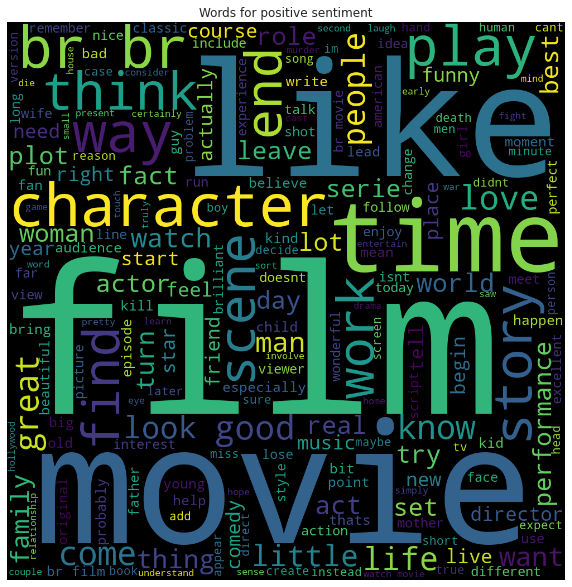

In [19]:
WC = WordCloud(width = 1000, height = 1000, 
                background_color ='black', 
                stopwords = stopword, 
                min_font_size = 10).generate(positive) 
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(WC)
plt.title('Words for positive sentiment')
plt.axis('off')

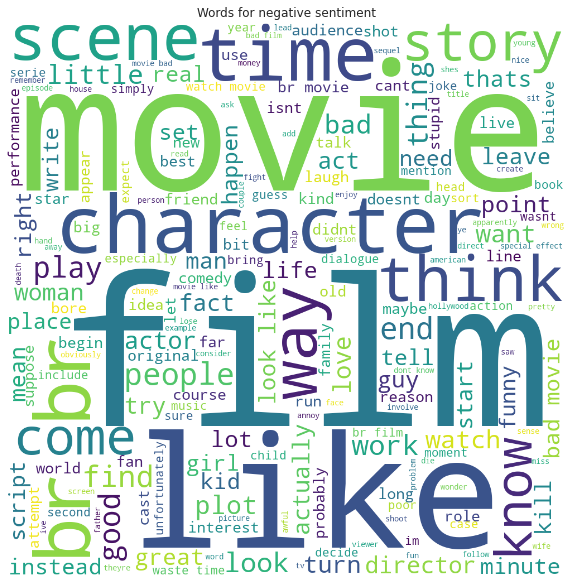

In [22]:
plt.figure(figsize=(10,10))
wc = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = stopword, 
                min_font_size = 10).generate(negative) 

plt.imshow(wc)
plt.title('Words for negative sentiment')
plt.axis('off')
plt.show() 

In [23]:
corpus = Movies_df['Clean_Reviews']
corpus.head()

0    reviewer mention watch oz episode youll hook r...
1    wonderful little production br br film techniq...
2    think wonderful way spend time hot summer week...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: Clean_Reviews, dtype: object

In [24]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = Movies_df.iloc[:, 1].values

In [62]:
# Creating a pickle file for the CountVectorizer
pickle.dump(cv, open('cv-transform.pkl', 'wb'))

**Model Building**

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [29]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
NB_Model = MultinomialNB()
NB_Model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
# Predicting the Test set results
y_pred = NB_Model.predict(X_test)

In [32]:
# Accuracy, Precision and Recall (evaluation metrics for classification)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Accuracy_Score = accuracy_score(y_test,y_pred)
Precision_Score = precision_score(y_test,y_pred)
Recall_Score = recall_score(y_test,y_pred)
print("---- Scores ----")
print("Accuracy score is: {}%".format(round(Accuracy_Score*100,2)))
print("Precision score is: {}".format(round(Precision_Score,2)))
print("Recall score is: {}".format(round(Recall_Score,2)))

---- Scores ----
Accuracy score is: 82.65%
Precision score is: 0.82
Recall score is: 0.83


In [34]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, y_pred)

Text(65.0, 0.5, 'Actual values')

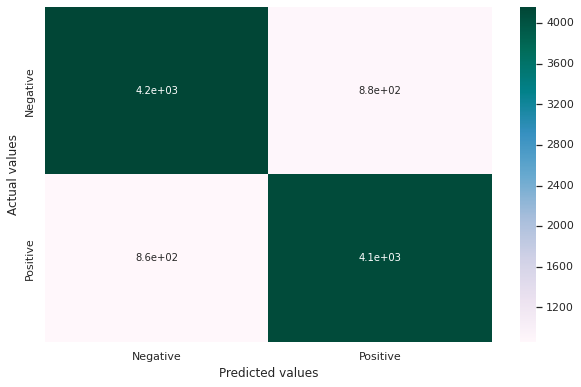

In [37]:
# Plotting the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10,6))
sns.heatmap(CM, annot=True, cmap="PuBuGn", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')

In [38]:
# Hyperparameter tuning the Naive Bayes Classifier

best_accuracy = 0.0
alpha_val = 0.0
for i in np.arange(0.1,1.9,0.1):
  NB_classifier = MultinomialNB(alpha=i)
  NB_classifier.fit(X_train, y_train)
  y_Pred = NB_classifier.predict(X_test)
  score = accuracy_score(y_test, y_Pred)
  print("Accuracy score for alpha={} is: {}%".format(round(i,1), round(score*100,2)))
  if score>best_accuracy:
    best_accuracy = score
    alpha_val = i
print('--------------------------------------------')
print('The best accuracy is {}% with alpha value as {}'.format(round(best_accuracy*100, 2), round(alpha_val,1)))

Accuracy score for alpha=0.1 is: 82.65%
Accuracy score for alpha=0.2 is: 82.65%
Accuracy score for alpha=0.3 is: 82.65%
Accuracy score for alpha=0.4 is: 82.65%
Accuracy score for alpha=0.5 is: 82.65%
Accuracy score for alpha=0.6 is: 82.65%
Accuracy score for alpha=0.7 is: 82.65%
Accuracy score for alpha=0.8 is: 82.65%
Accuracy score for alpha=0.9 is: 82.65%
Accuracy score for alpha=1.0 is: 82.65%
Accuracy score for alpha=1.1 is: 82.64%
Accuracy score for alpha=1.2 is: 82.64%
Accuracy score for alpha=1.3 is: 82.64%
Accuracy score for alpha=1.4 is: 82.64%
Accuracy score for alpha=1.5 is: 82.64%
Accuracy score for alpha=1.6 is: 82.64%
Accuracy score for alpha=1.7 is: 82.64%
Accuracy score for alpha=1.8 is: 82.63%
--------------------------------------------
The best accuracy is 82.65% with alpha value as 0.1


**Predictions**

In [41]:
def predict_sentiment(moview_review):
  temp = cv.transform([moview_review]).toarray()
  return NB_Model.predict(temp)

In [45]:
# Predicting sentiment
review = 'I would not watch Godzilla Vs Kong again. It is boring.'

if predict_sentiment(review):
  print('This is a POSITIVE review.')
else:
  print('This is a NEGATIVE review!')

This is a NEGATIVE review!


In [46]:

# Predicting sentiment
review1 = 'Fast and Furious trailer looks awesome.'

if predict_sentiment(review1):
  print('This is a POSITIVE review.')
else:
  print('This is a NEGATIVE review!')

This is a POSITIVE review.


**Random Forest Classifier**

In [48]:
from sklearn.ensemble import RandomForestClassifier
RF_Model = RandomForestClassifier()
RF_Model.fit(X_train, y_train)
y_pred_RF = RF_Model.predict(X_test)
print("Accuracy of Random Forest Classifier: {} %".format(round(accuracy_score(y_test, y_pred_RF)*100, 4)))

Accuracy of Random Forest Classifier: 82.79 %


In [53]:
#Selecting hyper-parameters in RandomForestClassifier

#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
#Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Method of selecting samples for training each tree
bootstrap = [True, False]

#Creating a random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [54]:
#Using RandomizedSearchCV for selecting best hyper-parameters
#On each iteration, the algorithm will choose a difference combination of the features
#the benefit of a random search is that we are not trying every combination, 
#but selecting at random to sample a wide range of values.

#n_iter = number of different combinations to try
#cv = number of folds to use for cross validation

randomizedSearch = RandomizedSearchCV(estimator=RF_Model,
                                     param_distributions=random_grid,
                                     n_iter=10,
                                     n_jobs=-1,
                                     cv=3,
                                     verbose=2,
                                     random_state=42)

randomizedSearch.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



KeyboardInterrupt: ignored

In [ ]:
#Best parameters after performing RandomizedSearchCV
print(randomizedSearch.best_params_)

#Getting the best estimator after performing RandomizedSearchCV
randomSearchModel = randomizedSearch.best_estimator_

y_pred = randomSearchModel.predict(X_test)

print("Accuracy of Random Forest Model after Hyperparameter Tuning: {} %".format(round(accuracy_score(y_test, y_pred)*100, 4)))

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
Accuracy : 83.51 %


**XGBoost**

In [ ]:
import xgboost
xgb_model = xgboost.XGBClassifier()

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_Pred_xgb = xgb_model.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_Pred_xgb)*100, 4)))

Accuracy : 79.05 %


In [ ]:
param_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [1, 3, 5, 7],
              "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]}

random_XGB = RandomizedSearchCV(estimator=xgb_model,
                               param_distributions=param_grid,
                               n_iter=20,
                               n_jobs=-1,
                               verbose=2,
                               cv=3,
                               random_state=42)

In [ ]:
XGB_model = random_XGB.estimator

print(random_XGB.get_params)

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1)

In [ ]:
y_pred_XGB = XGB_model.predict(X_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred_XGB)*100, 4)))

Accuracy : 79.05 %


**Logistic Regression**

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,2))

In [57]:
lr_model =LogisticRegression()
lr_model.fit(X_train,y_train)
pred_y=lr_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [58]:
print("Accuracy : {} %".format(round(accuracy_score(y_test, pred_y)*100, 4)))

Accuracy : 86.38 %


**Hyper-parameter Tuning**

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [ ]:
LR_Model = RandomSearchCV(lr_model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
LR_Model.fit(X_train, y_train)

NameError: ignored

In [ ]:
#Best parameters after performing GridSearchCV
print(LR_Model.best_params_)

#Getting the best estimator after performing GriddSearchCV
Log_Reg_Model = LR_Model.best_estimator_

y_pred = Log_Reg_Model.predict(X_test, y_test)

print("Accuracy : {} %".format(round(accuracy_score(y_test, y_pred)*100, 4)))

In [61]:
import pickle
# Creating a pickle file for the Multinomial Naive Bayes model
filename = 'LogReg-model.pkl'
pickle.dump(lr_model, open(filename, 'wb'))